In [1]:
# importing and installing
!pip install sqlalchemy
!pip install pyodbc

from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set()


In [2]:
# Creating an engine and connecting
engine = create_engine('mssql://Jcomp/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
connection = engine.connect()

In [3]:
# Querying database - Big picture of the AdventureWorks


In [4]:
# Total sales per year - SQL
sales_yrs ="""
SELECT YEAR(OrderDate) AS [Year], 
    ROUND(SUM(TotalDue), 2) / 1000000 AS Sales 
FROM Sales.SalesOrderHeader 
GROUP BY YEAR(OrderDate)
ORDER BY 1;
"""

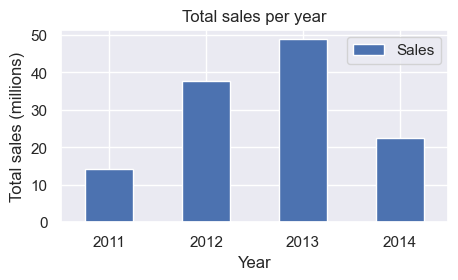

In [5]:
# Total sales per year - Plot
sales_yrs_df = pd.read_sql(sql=sales_yrs, con=connection)

sales_yrs_df.set_index('Year').plot(kind='bar', figsize=(5, 2.5))
plt.xticks(rotation=0)
plt.xlabel('Year')
plt.ylabel('Total sales (millions)')
plt.title('Total sales per year')
plt.show()

In [6]:
# Total purchase per year - SQL
purch_yrs ="""
SELECT YEAR(OrderDate) AS Year, 
    ROUND(SUM(TotalDue), 2) / 1000000 AS Purchases 
FROM Purchasing.PurchaseOrderHeader 
GROUP BY YEAR(OrderDate)
ORDER BY 1;
"""

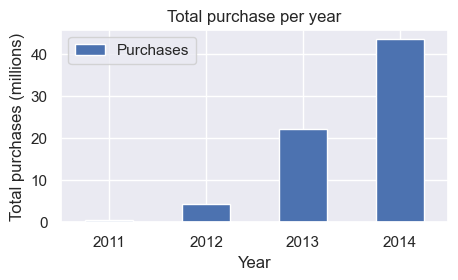

In [7]:
# Total purchase per year - Plot
purch_yrs_df = pd.read_sql(sql=purch_yrs, con=connection)

purch_yrs_df.set_index('Year').plot(kind='bar', figsize=(5, 2.5))
plt.xticks(rotation=0)
plt.xlabel('Year')
plt.ylabel('Total purchases (millions)')
plt.title('Total purchase per year')
plt.show()

In [8]:
# Number of employees in each Department Group - SQL
emp_dpt ="""
SELECT D.GroupName AS DepartmentGroup
    , COUNT(*) AS Employees
FROM HumanResources.Employee AS E
    INNER JOIN HumanResources.EmployeeDepartmentHistory AS H
        ON E.BusinessEntityID = H.BusinessEntityID
    INNER JOIN HumanResources.Department AS D
        ON H.DepartmentID = D.DepartmentID
GROUP BY D.GroupName
ORDER BY 2;
"""

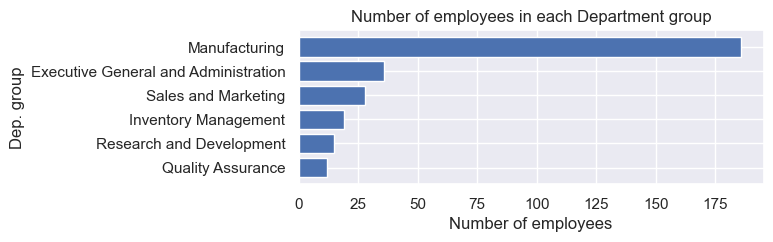

In [9]:
# Number of employees in each Department Group - Plot
emp_dpt_df = pd.read_sql(sql=emp_dpt, con=connection)

y=emp_dpt_df['DepartmentGroup']
x=emp_dpt_df['Employees']

plt.figure(figsize=(6,2))
plt.barh(y, x)
plt.ylabel("Dep. group")
plt.xlabel("Number of employees") 
plt.title("Number of employees in each Department group")
plt.show()

In [10]:
# Age distribution employees -SQL
age_dstr ="""
SELECT DATEDIFF(YY, BirthDate, GETDATE()) AS Age
    , COUNT(*) AS NbrOfPeople
FROM HumanResources.Employee
GROUP BY DATEDIFF(YY, BirthDate, GETDATE())
ORDER BY 1;
"""

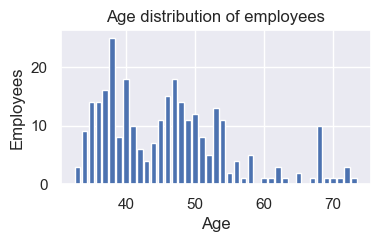

In [11]:
# Age distribution employees -Plot
age_dstr_df = pd.read_sql(sql=age_dstr, con=connection)

y=age_dstr_df['NbrOfPeople']
x=age_dstr_df['Age']

plt.figure(figsize=(4,2))
plt.bar(x, y)
plt.xlabel('Age')
plt.ylabel('Employees')
plt.title('Age distribution of employees')
plt.show()

In [12]:
# Gender distribution for each Department Group - SQL
gndr_dstr ="""
SELECT D.GroupName AS DepartmentGroup
    , ROUND(CAST(100 * COUNT(CASE WHEN E.Gender='M' THEN 1 END) AS FLOAT) / COUNT(*), 2) AS [Male(%)]
    , ROUND(CAST(100 * COUNT(CASE WHEN E.Gender='F' THEN 1 END) AS FLOAT) / COUNT(*), 2) AS [Female(%)]
FROM HumanResources.Employee AS E
    INNER JOIN HumanResources.EmployeeDepartmentHistory AS H
        ON E.BusinessEntityID = H.BusinessEntityID
    INNER JOIN HumanResources.Department AS D
        ON H.DepartmentID = D.DepartmentID
GROUP BY D.GroupName
ORDER BY 1;
"""

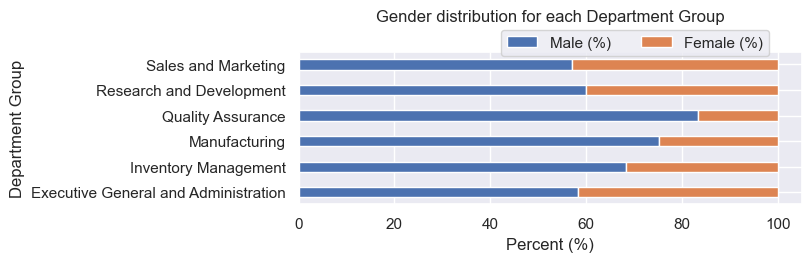

In [13]:
# Gender distribution for each Department Group - Plot
gndr_dstr_df = pd.read_sql(sql=gndr_dstr, con=connection)

y=gndr_dstr_df['DepartmentGroup']
width=0.4

fig, ax = plt.subplots(figsize=(8, 2.5), constrained_layout=True)

ax.barh(y, gndr_dstr_df['Male(%)'], width, label='Male (%)')
ax.barh(y, gndr_dstr_df['Female(%)'], width, left=gndr_dstr_df['Male(%)'], label='Female (%)')

plt.title('Gender distribution for each Department Group', y=1.15)
plt.legend(bbox_to_anchor =(0.95, 1.2), ncol = 2)
plt.xlabel('Percent (%)')
plt.ylabel('Department Group')
plt.show()

In [14]:
# Number of employees per shift for each Department group - SQL
shft_emp ="""
SELECT d.GroupName
    , COUNT(CASE WHEN edh.ShiftID = 1 THEN 1 END) AS Day
    , COUNT(CASE WHEN edh.ShiftID = 2 THEN 1 END) AS Evening
    , COUNT(CASE WHEN edh.ShiftID = 3 THEN 1 END) AS Night
FROM HumanResources.EmployeeDepartmentHistory AS edh
INNER JOIN HumanResources.Department AS d
    ON edh.DepartmentID = d.DepartmentID
GROUP BY d.GroupName
ORDER BY 1;
"""

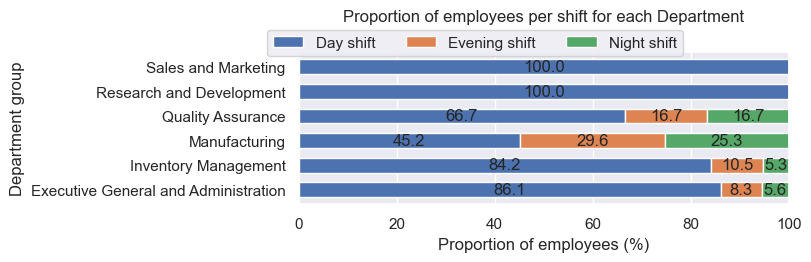

In [15]:
# Number of employees per shift for each Department group - Plot
shft_emp_df = pd.read_sql(sql=shft_emp, con=connection)
shft_emp_df = shft_emp_df.set_index('GroupName')
shft_emp_df = shft_emp_df.div(shft_emp_df.sum(axis=1), axis=0)*100  # omvandla till procent

y=shft_emp_df.index
width=0.6

fig, ax = plt.subplots(figsize=(8, 2.5), constrained_layout=True)

ax.barh(y, shft_emp_df['Day'], width, label='Day shift')
ax.barh(y, shft_emp_df['Evening'], width, left=shft_emp_df['Day'], label='Evening shift')
ax.barh(y, shft_emp_df['Night'], width, left=shft_emp_df['Day'] + shft_emp_df ['Evening'], label='Night shift')                        

for i, v in enumerate(shft_emp_df['Day']):
    plt.text(v * 0.5, i, str(round(v,1)), ha='center', va='center')

for i, v in enumerate(shft_emp_df['Evening']):
    if shft_emp_df['Evening'][i] > 0:
        plt.text(v * 0.5 + shft_emp_df['Day'][i], i, str(round(v,1)), ha='center', va='center')
    else:
        pass

for i, v in enumerate(shft_emp_df['Night']):
    if shft_emp_df['Night'][i] > 0:
        plt.text(v * 0.5 + shft_emp_df['Day'][i] + shft_emp_df['Evening'][i], i, str(round(v,1)), ha='center', va='center')
    else:
        pass
    
plt.title('Proportion of employees per shift for each Department', y=1.15)
plt.legend(bbox_to_anchor =(0.8, 1.2), ncol = 3)
plt.xlabel('Proportion of employees (%)')
plt.ylabel('Department group')
plt.show()

In [16]:
# Querying database - Deeper analysis of certain aspects


In [17]:
# Monthly sales for each product category during the whole period - SQL
# Plotting sales for each category to identify interesting patterns or relationships.

cat_sale ="""
SELECT FORMAT(soh.DueDate, 'yyyy-MM') AS Date
	, SUM(CASE WHEN ps.ProductCategoryID IN('4') THEN LineTotal END) / 1000000 AS Accessories
	, SUM(CASE WHEN ps.ProductCategoryID IN('1') THEN LineTotal END) / 1000000 AS Bikes
	, SUM(CASE WHEN ps.ProductCategoryID IN('3') THEN LineTotal END) / 1000000 AS Clothing
	, SUM(CASE WHEN ps.ProductCategoryID IN('2') THEN LineTotal END) / 1000000 AS Components
FROM Production.ProductCategory AS pc
INNER JOIN Production.ProductSubcategory AS ps
	ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
GROUP BY FORMAT(soh.DueDate, 'yyyy-MM')
ORDER BY 1;
"""

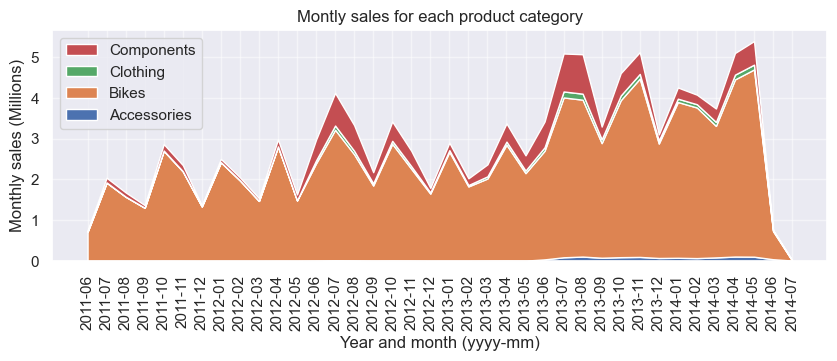

In [18]:
# Monthly sales for each product category during the whole period - Plot

cat_sale_df = pd.read_sql(sql=cat_sale, con=connection)
cat_sale_df = cat_sale_df.fillna(0)  # Missing values replaced by 0.

x=cat_sale_df['Date']
a=cat_sale_df['Accessories']
b=cat_sale_df['Bikes']
cl=cat_sale_df['Clothing']
co=cat_sale_df['Components']

plt.figure(figsize=(10, 3))
plt.stackplot(x, a, b, cl, co, labels=['Accessories', 'Bikes', 'Clothing', 'Components'])
plt.legend(loc='upper left', reverse=True)
plt.grid(True, alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Year and month (yyyy-mm)')
plt.ylabel('Monthly sales (Millions)')
plt.title('Montly sales for each product category')
plt.show()

In [19]:
# Sum units ordered from each product category during the whole period - SQL
# Plotting ordered units for each category to compare the volumes.

units_order ="""
SELECT FORMAT(soh.DueDate, 'yyyy-MM') AS Date
	, SUM(CASE WHEN pc.Name IN('Accessories') THEN sod.OrderQty END) AS Accessories
	, SUM(CASE WHEN pc.Name IN('Bikes') THEN sod.OrderQty END) AS Bikes
	, SUM(CASE WHEN pc.Name IN('Clothing') THEN sod.OrderQty END) AS Clothing
	, SUM(CASE WHEN pc.Name IN('Components') THEN sod.OrderQty END) AS Components
FROM Production.ProductCategory AS pc
INNER JOIN Production.ProductSubcategory AS ps
	ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
GROUP BY FORMAT(soh.DueDate, 'yyyy-MM')
ORDER BY 1;
"""

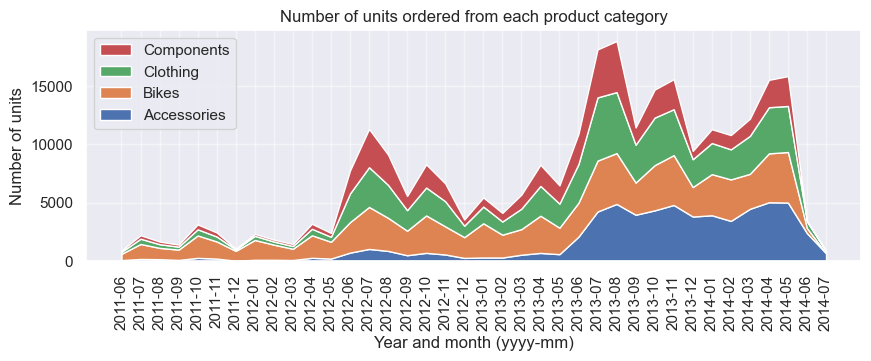

In [20]:
# Sum units ordered from each product category during the whole period - Plot

units_order_df = pd.read_sql(sql=units_order, con=connection)
units_order_df = units_order_df.fillna(0)  

x=units_order_df['Date']
a=units_order_df['Accessories']
b=units_order_df['Bikes']
cl=units_order_df['Clothing']
co=units_order_df['Components']

plt.figure(figsize=(10, 3))
plt.stackplot(x, a, b, cl, co, labels=['Accessories', 'Bikes', 'Clothing', 'Components'])
plt.legend(loc='upper left', reverse=True)
plt.grid(True, alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Year and month (yyyy-mm)')
plt.ylabel('Number of units')
plt.title('Number of units ordered from each product category')
plt.show()

In [21]:
# Bike sales per Continent - SQL
# By showing sales per Continent we can see any similarities or differences

tot_monthly ="""
SELECT FORMAT(DueDate, 'yyyy-MM') AS YearMonth
    , SUM(CASE WHEN TerritoryID IN(1,2,3,4,5,6) THEN LineTotal END) / 1000000 AS NorthAmerica
    , SUM(CASE WHEN TerritoryID IN(7,8,10) THEN LineTotal END) / 1000000 AS Europe
    , SUM(CASE WHEN TerritoryID IN(9) THEN LineTotal END) / 1000000 AS Pacific 
FROM Sales.SalesOrderHeader AS soh
INNER JOIN Sales.SalesOrderDetail AS sod
	ON soh.SalesOrderID = sod.SalesOrderID
INNER JOIN Production.Product AS p
	ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE ps.ProductCategoryID IN('1')
GROUP BY FORMAT(DueDate, 'yyyy-MM')
ORDER BY 1;
"""

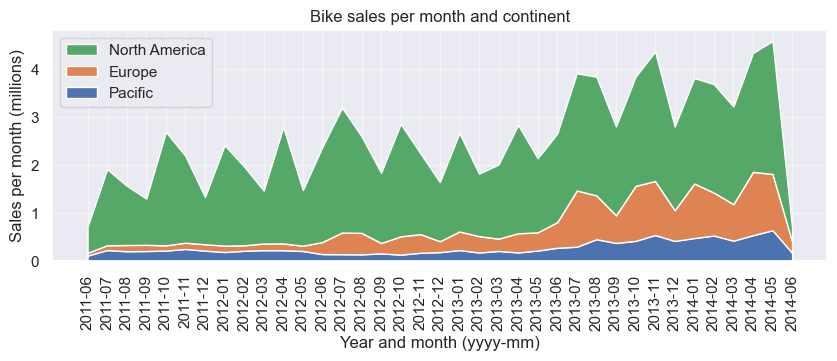

In [22]:
# Bike sales per Continent - Plot
tot_monthly_df = pd.read_sql(sql=tot_monthly, con=connection)

x=tot_monthly_df['YearMonth']
n_am=tot_monthly_df['NorthAmerica']
eu=tot_monthly_df['Europe']
pcf=tot_monthly_df['Pacific']

plt.figure(figsize=(10, 3))
plt.stackplot(x, pcf, eu, n_am, labels=['Pacific','Europe','North America'])
plt.legend(loc='upper left', reverse=True)
plt.grid(True, alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Year and month (yyyy-mm)')
plt.ylabel('Sales per month (millions)')
plt.title('Bike sales per month and continent')
plt.show()

In [23]:
# Sales for different bike types - SQL
# By showing sales per bike type we can see any similarities or differences

bike_sale ="""
SELECT FORMAT(soh.DueDate, 'yyyy-MM') AS Date
	, SUM(CASE WHEN ps.Name IN('Mountain Bikes') THEN LineTotal END) / 1000000 AS [Mountain Bikes]
	, SUM(CASE WHEN ps.Name IN('Road Bikes') THEN LineTotal END) / 1000000 AS [Road Bikes]
	, SUM(CASE WHEN ps.Name IN('Touring Bikes') THEN LineTotal END) / 1000000 AS [Touring Bikes]
FROM Production.Product AS p
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE ps.ProductCategoryID = 1
GROUP BY FORMAT(soh.DueDate, 'yyyy-MM')
ORDER BY 1;
"""

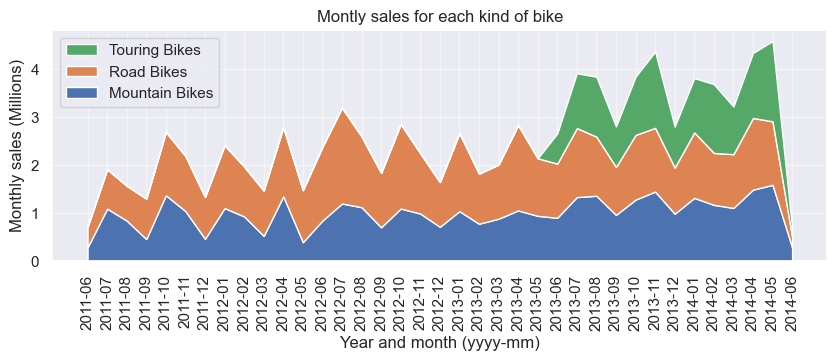

In [24]:
# Sales for different bike types - Plot

bike_sale_df = pd.read_sql(sql=bike_sale, con=connection)
bike_sale_df = bike_sale_df.fillna(0) 

x=bike_sale_df['Date']
m=bike_sale_df['Mountain Bikes']
r=bike_sale_df['Road Bikes']
t=bike_sale_df['Touring Bikes']

plt.figure(figsize=(10, 3))
plt.stackplot(x, m, r, t, labels=['Mountain Bikes', 'Road Bikes', 'Touring Bikes'])
plt.legend(loc='upper left', reverse=True)
plt.grid(True, alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Year and month (yyyy-mm)')
plt.ylabel('Monthly sales (Millions)')
plt.title('Montly sales for each kind of bike')
plt.show()

In [25]:
# Bike units sold per Order Date - SQL
# By looking at the number of ordered bike units per order date we see an interesting pattern

b_sold ="""
SELECT FORMAT(soh.OrderDate, 'yyyy-MM-dd') AS [Order date]
    , COUNT(sod.OrderQty) AS Quantity
FROM Production.Product as p
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
WHERE p.ProductSubcategoryID IN(1, 2, 3)
GROUP BY FORMAT(soh.OrderDate, 'yyyy-MM-dd')
ORDER BY 1;
"""

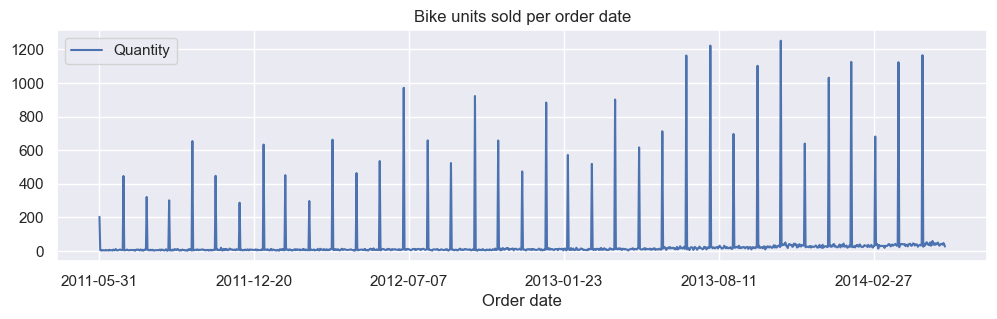

In [26]:
# Bike units sold per Order Date - Plot
b_sold_df = pd.read_sql(sql=b_sold, con=connection)

b_sold_df.plot(x='Order date', y='Quantity', figsize=(12, 3))
plt.title("Bike units sold per order date")
plt.show()

In [27]:
# Bike orders on peak order days - SQL
# By analysing CustomerID on "peak order days" it seems there is a pattern where one group of customers buys
# every third month with start on the first month, then a second group of customers buys every third month with start
# on the second month and a third group of customers buys every third month with start on the third month, 
# togetgher covering the whole period with monthly orderings.

peak ="""
SELECT FORMAT(soh.OrderDate, 'yyyy-MM-dd') AS [Order date]
    , COUNT(sod.OrderQty) AS Quantity
FROM Production.Product as p
INNER JOIN Production.ProductModel AS pm
	ON p.ProductModelID = pm.ProductModelID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
WHERE p.ProductSubcategoryID IN(1, 2, 3)
GROUP BY FORMAT(soh.OrderDate, 'yyyy-MM-dd')
HAVING COUNT(sod.OrderQty) > 100
ORDER BY 1;
"""

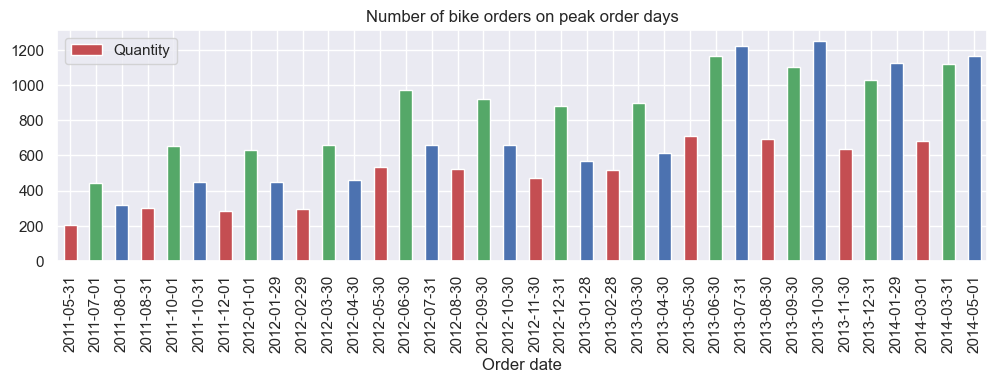

In [28]:
# Bike orders on peak order days - Plot

peak_df = pd.read_sql(sql=peak, con=connection)

c = ['r', 'g', 'b']
peak_df.plot(kind='bar', x='Order date', y='Quantity', color=c, figsize=(12, 3))
plt.title("Number of bike orders on peak order days")
plt.show()

In [29]:
# Unit selling prices per Category and year - SQL
agg_cat ="""
SELECT YEAR(soh.OrderDate) AS Year
	, CASE WHEN ps.ProductCategoryID IN('4') THEN 'Accessories' 
		WHEN ps.ProductCategoryID IN('1') THEN 'Bikes' 
		WHEN ps.ProductCategoryID IN('3') THEN 'Clothing' 
		WHEN ps.ProductCategoryID IN('2') THEN 'Components' END AS Category
	, (sod.LineTotal/sod.OrderQty) AS UnitPrice
FROM Production.ProductCategory AS pc
INNER JOIN Production.ProductSubcategory AS ps
	ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
ORDER BY 1;
"""

        count     mean      std     min     25%      50%      75%      max
Year                                                                      
2011   3826.0  1784.35  1258.73  397.37  419.46  2024.99  3393.74  3578.27
2012  10776.0  1263.95   922.84  164.43  469.79   874.79  2039.99  3578.27
2013  16485.0  1122.32   697.00  282.14  469.79  1020.59  1466.01  2443.35
2014   8944.0  1246.42   743.64   67.80  539.99  1120.49  1700.99  2443.35


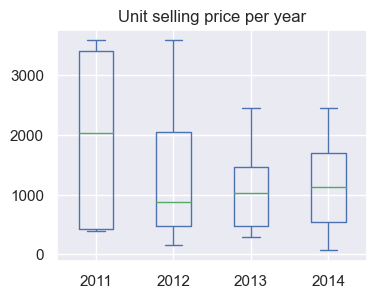

In [30]:
# Unit Price per year for Bikes - Plot
agg_cat_df = pd.read_sql(sql=agg_cat, con=connection)
agg_df = agg_cat_df[agg_cat_df['Category'] == 'Bikes'].pivot(columns='Year', values='UnitPrice')

print(agg_df.describe().round(2).T)

agg_df.plot.box(figsize=(4, 3))
plt.title('Unit selling price per year')
plt.show()

In [31]:
# Profit per category group - SQL
# Not included in report 
group_prof ="""
SELECT FORMAT(soh.OrderDate, 'yyyy-MM') AS OrderDate
	, CASE WHEN ps.ProductCategoryID IN('4') THEN 'Accessories' 
		WHEN ps.ProductCategoryID IN('1') THEN 'Bikes' 
		WHEN ps.ProductCategoryID IN('3') THEN 'Clothing' 
		WHEN ps.ProductCategoryID IN('2') THEN 'Components' END AS Category
	, AVG(sod.LineTotal/sod.OrderQty - p.StandardCost) AS AvgProfitPerUnit
	, SUM(sod.OrderQty) AS Units
	, SUM(sod.LineTotal - (sod.OrderQty*p.StandardCost)) AS TotalProfit
FROM Production.ProductSubcategory AS ps
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
GROUP BY FORMAT(soh.OrderDate, 'yyyy-MM'), ps.ProductCategoryID
ORDER BY 1;
"""

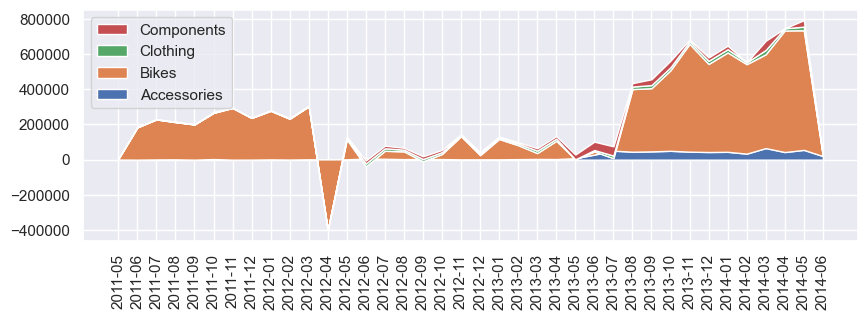

In [32]:
# Profit per category group - Plot
# Not included in report 
group_prof_df = pd.read_sql(sql=group_prof, con=connection)

df = group_prof_df.set_index('OrderDate').pivot(columns='Category', values='TotalProfit').fillna(0)

a=df['Accessories']
b=df['Bikes']
cl=df['Clothing']
co=df['Components']

plt.figure(figsize=(10, 3))
plt.stackplot(df.index, a, b, cl, co)
plt.legend(loc='upper left', reverse=True, labels=df.columns)
plt.xticks(rotation=90)
plt.show()

In [33]:
# Sale price vs unit cost for Bikes - SQL

cost_sell ="""
WITH date_cte AS (
	SELECT ProductID
		, StartDate
		, CASE WHEN EndDate IS NULL THEN '2014-12-31 00:00:00.000' ELSE EndDate END AS EndDate
		, StandardCost
	FROM Production.ProductCostHistory
)
SELECT FORMAT(soh.OrderDate, 'yyyy-MM-dd') AS Date
	, p.ProductID
	, (sod.LineTotal/sod.OrderQty) AS [Sale price]
	, date_cte.StandardCost AS [Unit cost]
	, ps.Name AS [Bike type]
FROM Production.ProductCategory AS pc
INNER JOIN Production.ProductSubcategory AS ps
	ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
LEFT JOIN date_cte
	ON p.ProductID = date_cte.ProductID 
		AND (soh.OrderDate BETWEEN date_cte.StartDate AND date_cte.EndDate)
WHERE ps.ProductSubcategoryID IN(1, 2, 3)
ORDER BY 1;
"""

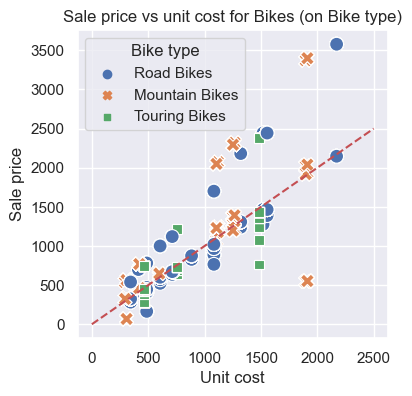

In [34]:
# Sale price vs unit cost for Bikes - Plot
# included a "break-even"-line where units above the line are sold with profit and units below are sold with loss.
cost_sell_df = pd.read_sql(sql=cost_sell, con=connection)


plt.figure(figsize=(4, 4))
sns.scatterplot(x=cost_sell_df["Unit cost"], y=cost_sell_df["Sale price"], hue=cost_sell_df["Bike type"], style=cost_sell_df["Bike type"], s=100)
plt.plot([0, 2500], [0, 2500], linestyle='dashed', color='r')
plt.title("Sale price vs unit cost for Bikes (on Bike type)")
plt.show()


In [35]:
# Sale price vs unit cost for Bikes (year) - SQL

c_s_year ="""
WITH date_cte AS (
	SELECT ProductID
		, StartDate
		, CASE WHEN EndDate IS NULL THEN '2014-12-31 00:00:00.000' ELSE EndDate END AS EndDate
		, StandardCost
	FROM Production.ProductCostHistory
)
SELECT YEAR(soh.OrderDate) AS Year
	, p.ProductID
	, (sod.LineTotal/sod.OrderQty) AS [Sale price]
	, date_cte.StandardCost AS [Unit cost]
	, ps.Name AS [Bike type]
FROM Production.ProductCategory AS pc
INNER JOIN Production.ProductSubcategory AS ps
	ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
LEFT JOIN date_cte
	ON p.ProductID = date_cte.ProductID 
		AND (soh.OrderDate BETWEEN date_cte.StartDate AND date_cte.EndDate)
WHERE ps.ProductSubcategoryID IN(1, 2, 3)
ORDER BY 1;
"""

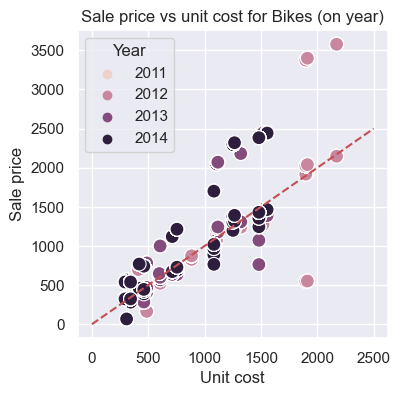

In [36]:
# Sale price vs unit cost for Bikes (year) - Plot
# included a "break-even"-line where units above the line are sold with profit and units below are sold with loss.
c_s_year_df = pd.read_sql(sql=c_s_year, con=connection)

plt.figure(figsize=(4, 4))
sns.scatterplot(x=c_s_year_df["Unit cost"], y=c_s_year_df["Sale price"], hue=c_s_year_df["Year"], s=100)
plt.plot([0, 2500], [0, 2500], linestyle='dashed', color='r')
plt.title("Sale price vs unit cost for Bikes (on year)")
plt.show()


In [37]:
# Finding outliers for Bikes - SQL
out ="""
WITH date_cte AS (
	SELECT ProductID
		, StartDate
		, CASE WHEN EndDate IS NULL THEN '2014-12-31 00:00:00.000' ELSE EndDate END AS EndDate
		, StandardCost
	FROM Production.ProductCostHistory
)
SELECT soh.OrderDate AS [Order date]
	, (sod.LineTotal/sod.OrderQty) AS [Sale price]
	, date_cte.StandardCost AS [Unit cost]
	, pm.Name AS [Bike model]
    , p.Color
    , COUNT(sod.OrderQty) AS Quantity
FROM Production.ProductCategory AS pc
INNER JOIN Production.ProductSubcategory AS ps
	ON pc.ProductCategoryID = ps.ProductCategoryID
INNER JOIN Production.Product AS p
	ON ps.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Production.ProductModel AS pm
    ON p.ProductModelID = pm.ProductModelID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
LEFT JOIN date_cte
	ON p.ProductID = date_cte.ProductID 
		AND (soh.OrderDate BETWEEN date_cte.StartDate AND date_cte.EndDate)
WHERE ps.ProductSubcategoryID IN(1, 2, 3)
    AND (sod.LineTotal/sod.OrderQty) < 1000 AND date_cte.StandardCost > 1750
GROUP BY soh.OrderDate
    , (sod.LineTotal/sod.OrderQty)
    , date_cte.StandardCost
    , pm.Name
    , p.Color
ORDER BY 2, 3;
"""

In [38]:
# Finding outliers for Bikes - Filtered print
out_df = pd.read_sql(sql=out, con=connection)
print(out_df)

# Turns out they are the last ones before the company stop selling those products.

  Order date  Sale price  Unit cost    Bike model   Color  Quantity
0 2012-04-30  548.435875  1898.0944  Mountain-100   Black        69
1 2012-04-30  552.498375  1912.1544  Mountain-100  Silver        68


In [39]:
# Analysing production quantity compared to order quantity to find any differences - SQL

# Production qty Bikes over time
p_time ="""
SELECT FORMAT(wo.StartDate, 'yyyy-MM') AS Date
	, ps.Name AS [Bike type]
	, SUM(wo.OrderQty) AS [Production quantity]
FROM Production.Product AS p
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
INNER JOIN Production.WorkOrder AS wo
	ON p.ProductID = wo.ProductID
WHERE ps.ProductSubcategoryID IN(1, 2, 3)
GROUP BY ps.Name
	, FORMAT(wo.StartDate, 'yyyy-MM')
ORDER BY 1;
"""

# Selling qty Bikes over time
s_time ="""
SELECT FORMAT(soh.DueDate, 'yyyy-MM') AS Date
	, ps.Name AS [Bike type]
	, SUM(sod.OrderQty) AS [Order quantity]
FROM Production.Product AS p
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
WHERE ps.ProductSubcategoryID IN(1, 2, 3)
GROUP BY ps.Name
	, FORMAT(soh.DueDate, 'yyyy-MM')
ORDER BY 1;
"""

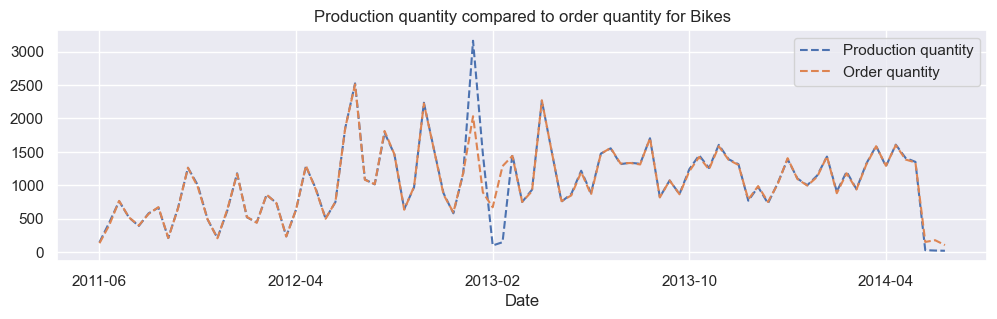

In [40]:
# Analysing production quantity compared to order quantity to find any differences - SQL
# Production qty vs Selling qty All Bikes over time
p_time_df = pd.read_sql(sql=p_time, con=connection)
s_time_df = pd.read_sql(sql=s_time, con=connection)

ax = p_time_df.set_index('Date').plot(kind='line', linestyle='dashed', figsize=(12, 3))
s_time_df.set_index('Date').plot(ax=ax, kind='line', linestyle='dashed')
plt.title('Production quantity compared to order quantity for Bikes')
plt.show()


In [41]:
# which Top 3 product subcategories are most usual in the same orders as bikes - SQL
usual_prod ="""
SELECT TOP 3 ps.Name
	, COUNT(sod.ProductID) AS Times
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Production.Product AS p
	ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE SalesOrderID IN(
		SELECT soh.SalesOrderID
		FROM Sales.SalesOrderDetail AS sod
		INNER JOIN Sales.SalesOrderHeader AS soh
			ON sod.SalesOrderID = soh.SalesOrderID
		INNER JOIN Production.Product AS p
			ON sod.ProductID = p.ProductID
		WHERE p.ProductSubcategoryID IN(1, 2, 3)
		)
	AND p.ProductSubcategoryID NOT IN(1, 2, 3)
GROUP BY ps.Name
ORDER BY 2 DESC;
"""

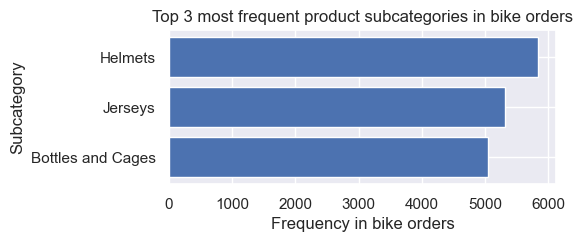

In [42]:
# which Top 3 product subcategories are most usual in the same orders as bikes - Plot
usual_prod_df = pd.read_sql(sql=usual_prod, con=connection)

x=usual_prod_df['Times']
y=usual_prod_df['Name']

plt.figure(figsize=(5, 2))
plt.barh(y, x)
plt.ylabel("Subcategory")
plt.xlabel("Frequency in bike orders") 
plt.title("Top 3 most frequent product subcategories in bike orders")
plt.gca().invert_yaxis()
plt.show()

In [43]:
# Helmets units sold
helm_sold ="""
SELECT FORMAT(soh.DueDate, 'yyyy-MM') AS Date
    , SUM(CASE WHEN p.ProductSubcategoryID = 31 THEN sod.OrderQty END) AS Quantity
FROM Production.Product as p
INNER JOIN Sales.SalesOrderDetail AS sod
	ON p.ProductID = sod.ProductID
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
GROUP BY FORMAT(soh.DueDate, 'yyyy-MM')
ORDER BY 1;
"""

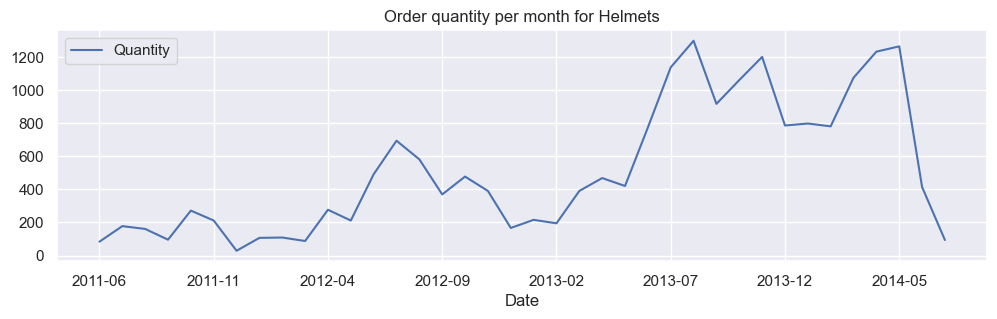

In [44]:
helm_sold_df = pd.read_sql(sql=helm_sold, con=connection)

helm_sold_df.set_index('Date').plot(figsize=(12, 3))
plt.title("Order quantity per month for Helmets")
plt.show()

In [45]:
#  helmet (id 31) in same order as bike - SQL

helm_frq ="""
SELECT sod.SalesOrderID
	, OrderDate
	, CASE WHEN p.ProductSubcategoryID = 31 THEN 1 ELSE 0 END AS Helmet
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product AS p
	ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE sod.SalesOrderID IN(
		SELECT DISTINCT soh.SalesOrderID
		FROM Sales.SalesOrderDetail AS sod
		INNER JOIN Sales.SalesOrderHeader AS soh
			ON sod.SalesOrderID = soh.SalesOrderID
		INNER JOIN Production.Product AS p
			ON sod.ProductID = p.ProductID
		WHERE p.ProductSubcategoryID IN(1, 2, 3)
		)
	AND p.ProductSubcategoryID NOT IN(1, 2, 3)
GROUP BY sod.SalesOrderID, OrderDate, p.ProductSubcategoryID
ORDER BY 1;
"""

In [57]:
# Confidence interval for average frequency for helmet in same order as bike.

frq_df = pd.read_sql(sql=helm_frq, con=connection)
frq = frq_df.Helmet

ci = stats.norm.interval(0.95, loc=np.mean(frq), scale=stats.sem(frq))

print(f"Average frequency for helmet in the same order as bike: {np.mean(frq)}")
print(f"Confidence interval for average frequency for helmet in same order as bike: {ci}")

Average frequency for helmet in the same order as bike: 0.14586011604878218
Confidence interval for average frequency for helmet in same order as bike: (0.14178222635103646, 0.1499380057465279)


In [ ]:
# Results below are not included in the report

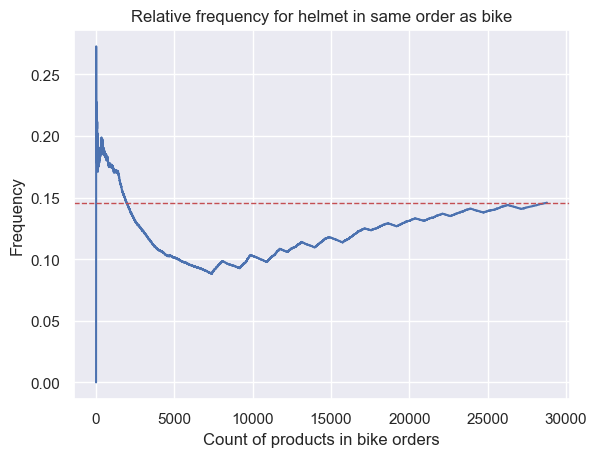

In [47]:
# show relative frequency over time

rel = []                   
n1 = 0
n2 = 0

for i in range(len(frq)):
    if frq[i] == 1:
        n1 += 1
    n2 += 1
    rel.append(n1/n2)   
    
plt.plot(rel)
plt.axhline(np.mean(frq), color = 'r', linestyle = '--', lw = 1)
plt.xlabel('Count of products in bike orders')
plt.ylabel('Frequency')
plt.title('Relative frequency for helmet in same order as bike')
plt.show()

In [48]:
#  helmet (id 31) in same order as bike - year 2012
freq2012 ="""
SELECT sod.SalesOrderID
	, OrderDate
	, CASE WHEN p.ProductSubcategoryID = 31 THEN 1 ELSE 0 END AS Helmet
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product AS p
	ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE sod.SalesOrderID IN(
		SELECT DISTINCT soh.SalesOrderID
		FROM Sales.SalesOrderDetail AS sod
		INNER JOIN Sales.SalesOrderHeader AS soh
			ON sod.SalesOrderID = soh.SalesOrderID
		INNER JOIN Production.Product AS p
			ON sod.ProductID = p.ProductID
		WHERE p.ProductSubcategoryID IN(1, 2, 3)
		)
	AND p.ProductSubcategoryID NOT IN(1, 2, 3)
    AND Year(OrderDate) = 2012
GROUP BY sod.SalesOrderID, OrderDate, p.ProductSubcategoryID
ORDER BY 1;
"""

In [49]:
# Confidence interval for average frequency for helmet in same order as bike. (year 2012)
freq2012_df = pd.read_sql(sql=freq2012, con=connection)
f12 = freq2012_df.Helmet

ci = stats.norm.interval(0.95, loc=np.mean(f12), scale=stats.sem(f12))

print(f"Average frequency for helmet in the same order as bike: {np.mean(f12)}")
print(f"Confidence interval for average frequency for helmet in same order as bike: {ci}")

Average frequency for helmet in the same order as bike: 0.08682495344506518
Confidence interval for average frequency for helmet in same order as bike: (0.07840391201109993, 0.09524599487903042)


In [50]:
#  helmet (id 31) in same order as bike - year 2013
freq2013 ="""
SELECT sod.SalesOrderID
	, OrderDate
	, CASE WHEN p.ProductSubcategoryID = 31 THEN 1 ELSE 0 END AS Helmet
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product AS p
	ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE sod.SalesOrderID IN(
		SELECT DISTINCT soh.SalesOrderID
		FROM Sales.SalesOrderDetail AS sod
		INNER JOIN Sales.SalesOrderHeader AS soh
			ON sod.SalesOrderID = soh.SalesOrderID
		INNER JOIN Production.Product AS p
			ON sod.ProductID = p.ProductID
		WHERE p.ProductSubcategoryID IN(1, 2, 3)
		)
	AND p.ProductSubcategoryID NOT IN(1, 2, 3)
    AND Year(OrderDate) = 2013
GROUP BY sod.SalesOrderID, OrderDate, p.ProductSubcategoryID
ORDER BY 1;
"""

In [51]:
# Confidence interval for average frequency for helmet in same order as bike. (year 2013)
freq2013_df = pd.read_sql(sql=freq2013, con=connection)
f13 = freq2013_df.Helmet

ci = stats.norm.interval(0.95, loc=np.mean(f13), scale=stats.sem(f13))

print(f"Average frequency for helmet in the same order as bike: {np.mean(f13)}")
print(f"Confidence interval for average frequency for helmet in same order as bike: {ci}")

Average frequency for helmet in the same order as bike: 0.1364214992927864
Confidence interval for average frequency for helmet in same order as bike: (0.1307639146026679, 0.14207908398290492)


In [52]:
#  helmet (id 31) in same order as bike - year 2011
freq2011 ="""
SELECT sod.SalesOrderID
	, OrderDate
	, CASE WHEN p.ProductSubcategoryID = 31 THEN 1 ELSE 0 END AS Helmet
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product AS p
	ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE sod.SalesOrderID IN(
		SELECT DISTINCT soh.SalesOrderID
		FROM Sales.SalesOrderDetail AS sod
		INNER JOIN Sales.SalesOrderHeader AS soh
			ON sod.SalesOrderID = soh.SalesOrderID
		INNER JOIN Production.Product AS p
			ON sod.ProductID = p.ProductID
		WHERE p.ProductSubcategoryID IN(1, 2, 3)
		)
	AND p.ProductSubcategoryID NOT IN(1, 2, 3)
    AND Year(OrderDate) = 2011
GROUP BY sod.SalesOrderID, OrderDate, p.ProductSubcategoryID
ORDER BY 1;
"""

In [53]:
# Confidence interval for average frequency for helmet in same order as bike. (year 2011)
freq2011_df = pd.read_sql(sql=freq2011, con=connection)
f11 = freq2011_df.Helmet

ci = stats.norm.interval(0.95, loc=np.mean(f11), scale=stats.sem(f11))

print(f"Average frequency for helmet in the same order as bike: {np.mean(f11)}")
print(f"Confidence interval for average frequency for helmet in same order as bike: {ci}")

Average frequency for helmet in the same order as bike: 0.17699115044247787
Confidence interval for average frequency for helmet in same order as bike: (0.15037700205277252, 0.20360529883218323)


In [54]:
#  helmet (id 31) in same order as bike - year 2014
freq2014 ="""
SELECT sod.SalesOrderID
	, OrderDate
	, CASE WHEN p.ProductSubcategoryID = 31 THEN 1 ELSE 0 END AS Helmet
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Sales.SalesOrderHeader AS soh
	ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product AS p
	ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS ps
	ON p.ProductSubcategoryID = ps.ProductSubcategoryID
WHERE sod.SalesOrderID IN(
		SELECT DISTINCT soh.SalesOrderID
		FROM Sales.SalesOrderDetail AS sod
		INNER JOIN Sales.SalesOrderHeader AS soh
			ON sod.SalesOrderID = soh.SalesOrderID
		INNER JOIN Production.Product AS p
			ON sod.ProductID = p.ProductID
		WHERE p.ProductSubcategoryID IN(1, 2, 3)
		)
	AND p.ProductSubcategoryID NOT IN(1, 2, 3)
    AND Year(OrderDate) = 2014
GROUP BY sod.SalesOrderID, OrderDate, p.ProductSubcategoryID
ORDER BY 1;
"""

In [55]:
# Confidence interval for average frequency for helmet in same order as bike. (year 2014)
freq2014_df = pd.read_sql(sql=freq2014, con=connection)
f14 = freq2014_df.Helmet

ci = stats.norm.interval(0.95, loc=np.mean(f14), scale=stats.sem(f14))

print(f"Average frequency for helmet in the same order as bike: {np.mean(f14)}")
print(f"Confidence interval for average frequency for helmet in same order as bike: {ci}")

Average frequency for helmet in the same order as bike: 0.18379736236131464
Confidence interval for average frequency for helmet in same order as bike: (0.1760304780486175, 0.19156424667401178)
